In [21]:
import os 
import json
from datetime import datetime

import math
import numpy as np

from utils.input import setup, exercise_to_input

# Setttings

In [52]:
data_set = 'healthy'
#'patients'
#

In [53]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [54]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', data_set)

In [55]:
CONFIG = setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

In [56]:
CONFIG

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'LefteyeMidbottom': 'orbital',
  'LefteyeMidtop': 'orbital',
  'LefteyeInnercorner': 'orbital',
  'LefteyeOutercorner': 'orbital',
  'LefteyebrowInner': 'frontal',
  'LefteyebrowCenter': 'frontal',
  'RighteyeMidbottom': 'orbital',
  'RighteyeMidtop': 'orbital',
  'RighteyeInnercorner': 'orbital',
  'RighteyeOutercorner': 'orbital',
  'RighteyebrowInner': 'frontal',
  'RighteyebrowCenter': 'frontal',
  'NoseTip': 'frontal',
  'MouthLowerlipMidbottom': 'oral',
  'MouthLeftcorner': 'oral',
  'MouthRightcorner': 'oral',
  'MouthUpperlipMidtop': 'oral',
  'ChinCenter': 'oral',
  'ForeheadCenter': 'frontal',
  'LeftcheekCenter': 'oral',
  'RightcheekCenter': 'oral'},
 'BASES': {'LefteyeMidbottom': 'ForeheadCenter',
  'LefteyeMidtop': 'ForeheadCenter',
  'LefteyeInnercorner': 'ForeheadCenter',
  'LefteyeOutercorner': 'ForeheadCenter',
  'LefteyebrowInner': 'ForeheadCenter',
  'LefteyebrowCenter': 'ForeheadCenter

# Load all the sessions

In [57]:
def get_patient_id(file):
    return file.split('_')[0]

In [58]:
def get_session_id(file):
    return file.split('_')[1]

load all the sessions to a dictionary

In [59]:
patients_sessions = {}

for file_name in os.listdir(dir_exercises):
    if file_name == '.DS_Store': continue
    
    exercise = json.load(open(os.path.join(dir_exercises, file_name), 'r'))
    
    patient_id = get_patient_id(file_name)
    session_id = get_session_id(file_name)
    exercise_id = exercise['meta']['id']
    
    if patient_id not in patients_sessions:
        patients_sessions[patient_id] = {}
        
    if session_id not in patients_sessions[patient_id]:
        patients_sessions[patient_id][session_id] = {}
        
    data = []
    
    for poi in sorted(CONFIG['REGIONS'].keys()):
        if poi not in exercise['pois']:
            print(f'!WARNING: {poi} is not present in {file_name}')
            continue
            
        data.append({
            'xs': exercise['pois'][poi]['xs'],
            'ys': exercise['pois'][poi]['ys'],
            'zs': exercise['pois'][poi]['zs']
        })
        
    patients_sessions[patient_id][session_id][exercise_id] = data    

# Observations

In [60]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [61]:
def patient_amount(data):
    return len(data)

In [62]:
def sessions_amount(data):
    sessions = 0
    for patient_id in data:
        sessions += len(data[patient_id])
    
    return sessions

In [63]:
print(f'Overal number of patients:{patient_amount(patients_sessions)}')

Overal number of patients:79


In [64]:
print(f'Overal number of sessions:{sessions_amount(patients_sessions)}')

Overal number of sessions:80


## Exercises length distribution

In [65]:
def get_sessions_lengts(data):
    lengths = []
    for patient_id in data:
        for session_id in data[patient_id]:
            for exercise_id in data[patient_id][session_id]:
                lengths.append(len(data[patient_id][session_id][exercise_id][0]['xs']))
    return lengths

Number of exercises: 701


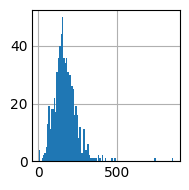

In [66]:
dist = get_sessions_lengts(patients_sessions)

print(f'Number of exercises: {len(dist)}')

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(dist, bins=100)
plt.show()

In [67]:
def show_problematic_exercises(data, lower_limit=100):
    lengths = []
    for patient_id in data:
        for session_id in data[patient_id]:
            for exercise_id in data[patient_id][session_id]:
                if len(data[patient_id][session_id][exercise_id][0]['xs']) < lower_limit:
                    print(f'Short exercise: Patient {patient_id} Session {session_id} Exercise {exercise_id}')

In [68]:
show_problematic_exercises(patients_sessions, lower_limit = 50)

Short exercise: Patient 246 Session 404 Exercise 06
Short exercise: Patient 246 Session 404 Exercise 03
Short exercise: Patient 178 Session 335 Exercise 03
Short exercise: Patient 178 Session 335 Exercise 02
Short exercise: Patient 166 Session 322 Exercise 07
Short exercise: Patient 231 Session 389 Exercise 04
Short exercise: Patient 219 Session 377 Exercise 05
Short exercise: Patient 219 Session 377 Exercise 04
Short exercise: Patient 219 Session 377 Exercise 08
Short exercise: Patient 210 Session 368 Exercise 02


# Visualise excercises

In [69]:
import tsaug
from tsaug.visualization import plot

In [70]:
exercise_id = 0
poi_id = 2

In [71]:
def exercise_min_max(data):
    min_xs = 2
    max_xs = -2
    min_ys = 2
    max_ys = -2
    min_zs = 2
    max_zs = -2
    for patient_id in sorted(data.keys()):
        for session_id in data[patient_id]:
            if exercise_id in data[patient_id][session_id]:
                for serieses in data[patient_id][session_id][exercise_id]:
                    min_xs = min([min_xs, min(serieses['xs'])])
                    max_xs = max([max_xs, max(serieses['xs'])])
                    min_ys = min([min_ys, min(serieses['ys'])])
                    max_ys = max([max_ys, max(serieses['ys'])])
                    min_zs = min([min_zs, min(serieses['zs'])])
                    max_zs = max([max_zs, max(serieses['zs'])])
    print(f'min_xs = {min_xs}')
    print(f'max_xs = {max_xs}')
    print(f'min_ys = {min_ys}')
    print(f'max_ys = {max_ys}')
    print(f'min_zs = {min_zs}')
    print(f'max_zs = {max_zs}')

In [72]:
exercise_min_max(patients_sessions)

min_xs = 2
max_xs = -2
min_ys = 2
max_ys = -2
min_zs = 2
max_zs = -2


In [73]:
def exercise_serieses(data):
    for patient_id in sorted(data.keys()):
        for session_id in data[patient_id]:
            if exercise_id in data[patient_id][session_id]:
                series = np.array(data[patient_id][session_id][exercise_id][poi_id]['xs'])
                #print(patient_id)
                plot(series)

In [74]:
#exercise_serieses(patients_sessions)

Weird! the healthy patient data doesn't look as data we had. We need to dig deeper

# Descriptive statistics

In [75]:
from utils.transformations import distance
import pandas as pd

In [83]:
target_poi = 'LefteyeMidbottom'

In [84]:
POIS = sorted(CONFIG['REGIONS'].keys())

In [85]:
def collect_stats(exercise):
    if 'age' not in exercise['meta']:
        return {}
        
        
    data = {}
    data['age_bucket'] = float(exercise['meta']['age']) // 10
    data['exercise_id'] = int(exercise['meta']['id'])
    data['sex'] = exercise['meta']['sex'] == 'SexEnum.FEMALE'
    data['length'] = 1.0 * len(exercise['pois'][target_poi]['xs'])
    
    for poi in POIS:
        data[f'distance_{poi}'] = sum(distance(
            exercise['pois'][poi]['xs'],
            exercise['pois'][poi]['ys'],
            exercise['pois'][poi]['zs']))
        data[f'distance_norm_{poi}'] = data[f'distance_{poi}'] / data['length']
    total_distance = 0
    for poi in POIS:
        total_distance += data[f'distance_{poi}']
    
    data[f'distance_total'] = total_distance
    data[f'distance_norm_total'] = total_distance / data['length']
    
    return data

In [86]:
stats = []

In [87]:
for file_name in os.listdir(dir_exercises):
    if file_name == '.DS_Store': continue
    
    exercise = json.load(open(os.path.join(dir_exercises, file_name), 'r')) 
    stats.append(collect_stats(exercise))

In [88]:
df = pd.DataFrame.from_records(stats)

In [89]:
df.head()

,age_bucket,exercise_id,sex,length,distance_ChinCenter,distance_norm_ChinCenter,distance_ForeheadCenter,distance_norm_ForeheadCenter,distance_LeftcheekCenter,distance_norm_LeftcheekCenter,...,distance_RighteyeMidtop,distance_norm_RighteyeMidtop,distance_RighteyeOutercorner,distance_norm_RighteyeOutercorner,distance_RighteyebrowCenter,distance_norm_RighteyebrowCenter,distance_RighteyebrowInner,distance_norm_RighteyebrowInner,distance_total,distance_norm_total
0,3.0,6,True,192.0,0.280796,0.001462,0.175962,0.000916,0.197869,0.001031,...,0.164058,0.000854,0.159340,0.000830,0.187010,0.000974,0.179380,0.000934,4.054800,0.021119
1,5.0,6,False,4.0,0.009049,0.002262,0.003354,0.000839,0.005636,0.001409,...,0.003648,0.000912,0.004573,0.001143,0.005193,0.001298,0.004223,0.001056,0.103644,0.025911
2,4.0,5,False,132.0,0.311472,0.002360,0.169667,0.001285,0.254081,0.001925,...,0.180506,0.001367,0.209239,0.001585,0.203995,0.001545,0.200853,0.001522,4.665278,0.035343
3,2.0,9,False,299.0,0.813615,0.002721,0.844975,0.002826,0.711546,0.002380,...,0.802020,0.002682,0.805993,0.002696,0.872928,0.002919,0.823466,0.002754,16.378018,0.054776
4,6.0,9,False,466.0,1.556996,0.003341,1.577588,0.003385,1.402868,0.003010,...,1.452657,0.003117,1.440789,0.003092,1.578662,0.003388,1.565918,0.003360,31.268395,0.067100


In [98]:
def visualise_stats(stat, max_y = 100):
    fig, axs = plt.subplots(1,9,figsize=(40,5)) 

    for exercise_id in range(0, 9):
        ex_df = df.loc[df['exercise_id'] == exercise_id + 1][['age_bucket', stat]]
        plot = ex_df.boxplot(by='age_bucket', ax=axs[exercise_id])
        plot.set_ylim([0, max_y])
    #plt.xticks(rotation=90)
    #plt.tight_layout() 
    plt.show()
   


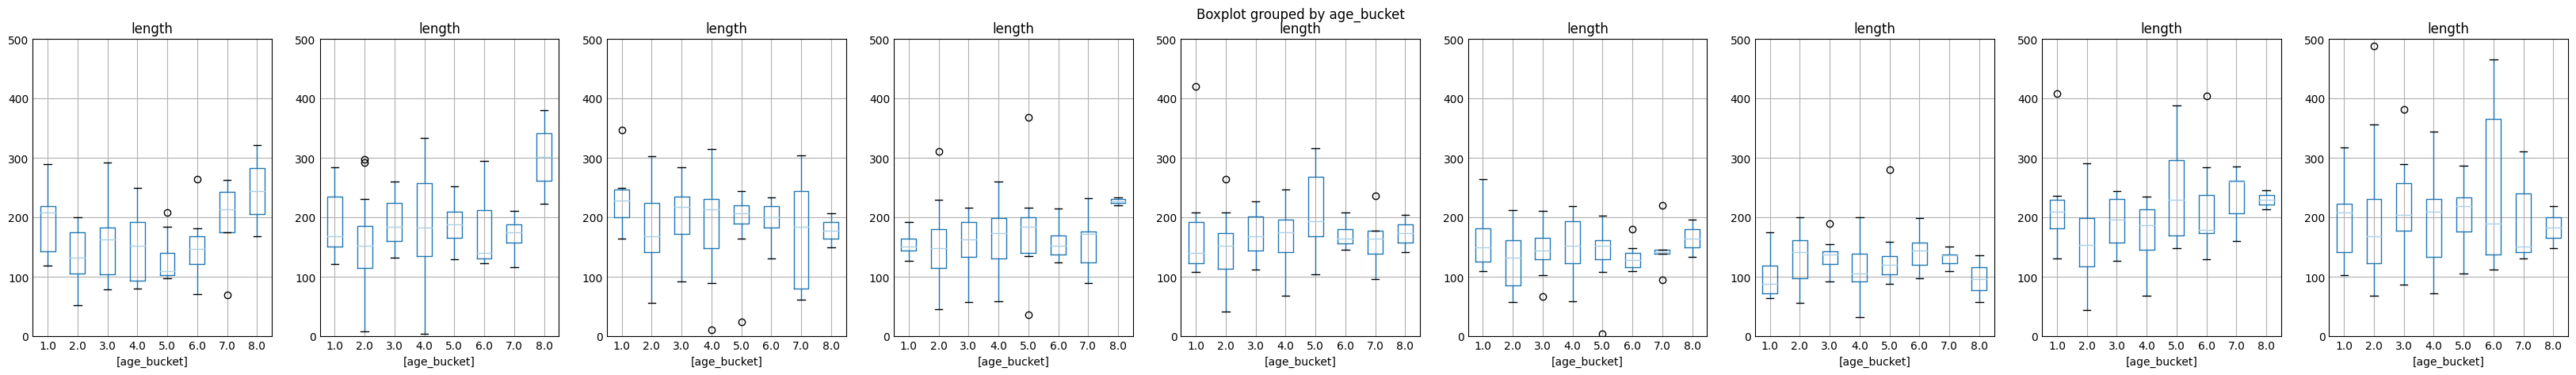

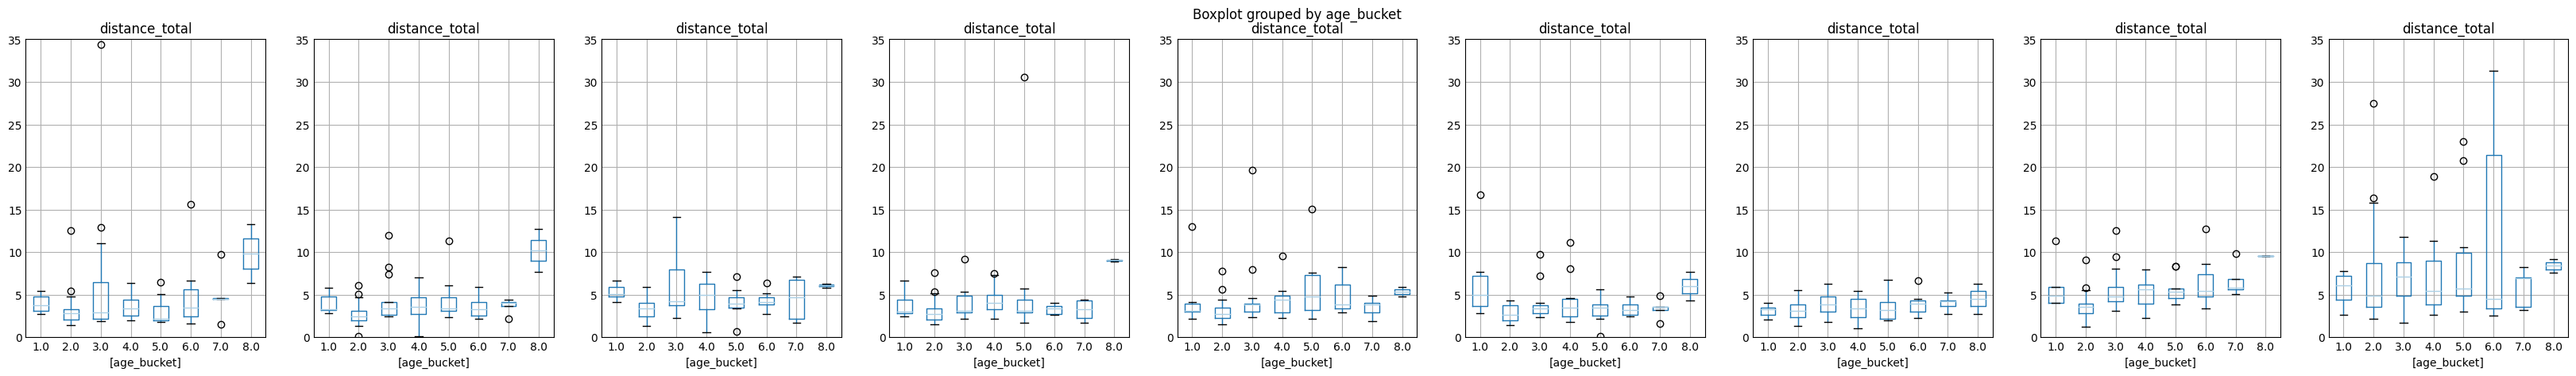

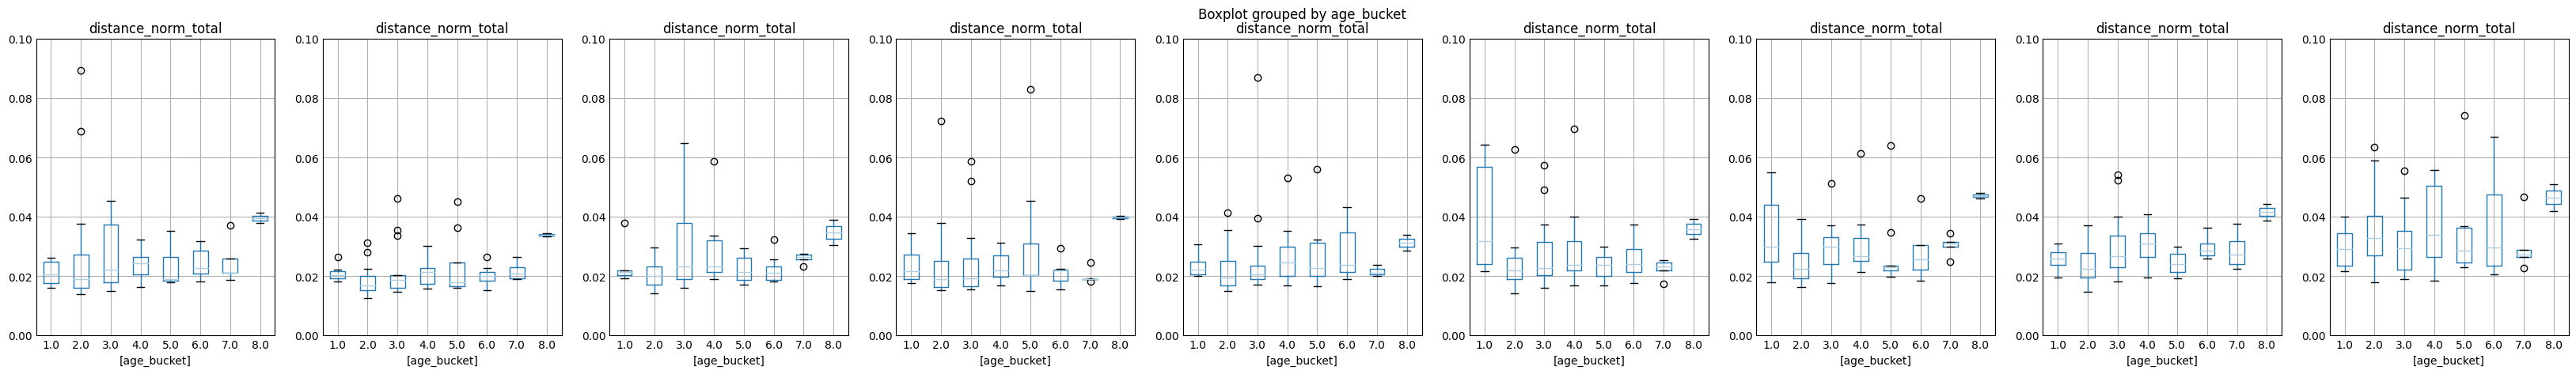

In [101]:
visualise_stats('length', max_y = 500)
visualise_stats('distance_total', max_y = 35)
visualise_stats('distance_norm_total', max_y = 0.1)

In [ ]:
todo distnaces for left and right aka assymetry